# **Test on the capabilities of our model** 🏋

In [69]:
from model import *
from optax import adam
from src.datagen import Equations
import os
from jax import jit, vmap, random
import jax
import matplotlib.pyplot as plt
import time
import scienceplots

jax.config.update("jax_enable_x64", True)
plt.style.use('science')

## Test the purely raw model

In [94]:
state_variables = 2
expected_number_of_nls = 2
input_dim = state_variables * expected_number_of_nls
output_dim = state_variables

model = ZeroLayersNN(N=input_dim, L=expected_number_of_nls, output_dim=state_variables)
seed = 42
batch_size = 32


dummy_input = jnp.zeros((batch_size, input_dim))
key = random.key(seed)
key, subkey = random.split(key)
params = model.init(subkey, dummy_input)
optimizer = adam(learning_rate=0.001)
state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

Then we create the random non linearities:

- **generate_alphabeta**: This function generates orthonormal basis vectors using QR decomposition. It takes three parameters: `dim` (the dimension of the matrix), `num` (the number of basis vectors), and `seed` (a seed for random number generation). The function creates a random matrix `A` of shape `(dim, num)` and then performs QR decomposition on `A` to obtain an orthonormal matrix `Q`. The function returns `Q`.
- **generate_callable_functions**: This function generates a set of callable functions based on the orthonormal basis vectors generated by `generate_alphabeta`. It takes three parameters: `dim` (the dimension of the matrix), `num` (the number of functions to generate), and `seed` (a seed for random number generation). The function splits the basis vectors into three parts: `alphas`, `betas`, and `gammas`. It then defines a nested function `make_function` that creates a callable function using these vectors. The `make_function` uses JAX's `jit` decorator to compile the function for faster execution. The main function returns a tuple containing the generated functions and the transposed basis vectors.

In [95]:
def generate_alphabeta(dim, num, seed):

    key = random.key(seed)
    shape = (dim, num)
    A = random.normal(key, shape)
    Q, _ = jnp.linalg.qr(A)
    return Q * 10

def generate_callable_functions(dim, num, seed):

    bases = generate_alphabeta(dim, num, seed)  # Get num basis vectors
   
    alphas = bases[:dim//2, :].T  # First half of Q are alphas
    gammas = bases[dim//2:, :].T

    def make_function(alpha, gamma):
        @jit
        def func(x):
            return (alpha[0] * nn.relu(x + gamma[0]) +
                    alpha[1] * nn.relu(x + gamma[1]) +
                    alpha[2] * nn.relu(x + gamma[2]))
        return func
    
    return tuple([make_function(alphas[i], gammas[i]) for i in range(num)]), bases.T

Now we want to work with the simplest case possible.


In [113]:
dims = 6
n_nls = 2
alphabeta = generate_alphabeta(dims, n_nls, seed)
non_lins, vec_nls = generate_callable_functions(dims, n_nls, seed)

config = {
    "n_vars": state_variables,
    "n_eqs": state_variables,
    "bounds_addends": (1, 1),
    "bounds_multiplicands": (1, 1),
    "non_lins": non_lins,
    "sym_non_lins": None,
    "distribution": "uniform",
    "a": None,
    "b": None,
    "sigma": None,
    "p": None,
    "seed": seed
}

In [114]:
save_dir = "Data"
filename = "Test"

system = Equations(**config)
system.save_symb_expr(filename=os.path.join(save_dir, filename+'_symbolic.pdf'))

PDF already exists


### Linspace

Let's try to train the model with data sampled by linspace. The test set is taken out of bounds with respect to the training data, in such way it is possible to verify the generalization abilities of the model.

In [115]:
def my_eval(v):
    return system(y=v)

In [116]:
bound = 15
train_size = int(1e4)
test_ratio = 0.2
test_size = int(test_ratio * train_size)
total_size = train_size + test_size
train_values = jnp.tile(jnp.linspace(-1 * bound, bound, total_size).reshape(-1, 1), (1, config['n_eqs']))

# Randomly select `test_size` elements for inbound_test
key = random.key(seed)
key, subkey = random.split(key)  # Ensure reproducibility
indices = random.choice(subkey, total_size, shape=(test_size,), replace=False)  # Unique indices
inbound_test = train_values[indices]  # Extract test points
mask = jnp.ones(total_size, dtype=bool)
mask = mask.at[indices].set(False)  # Mask out test points
train_values = train_values[mask]  # Remove test points from training set

# Create out-of-bound test values
range1 = jnp.linspace(-1 * bound - 5, -1 * bound, test_size//2)
range2 = jnp.linspace(bound, bound + 5, test_size//2)
outofbound_test = jnp.concatenate((range1, range2), axis=0).reshape(-1, 1)
outofbound_test = jnp.tile(outofbound_test, (1, config['n_eqs']))

# Stack both test sets
stacked_test = jnp.vstack((inbound_test, outofbound_test))

# Concatenate train and test values
values = jnp.vstack((train_values, stacked_test))

# Evaluate
evaluated_values = vmap(my_eval)(values)

In [117]:
print(train_values.shape, inbound_test.shape, outofbound_test.shape)

(10000, 2) (2000, 2) (2000, 2)


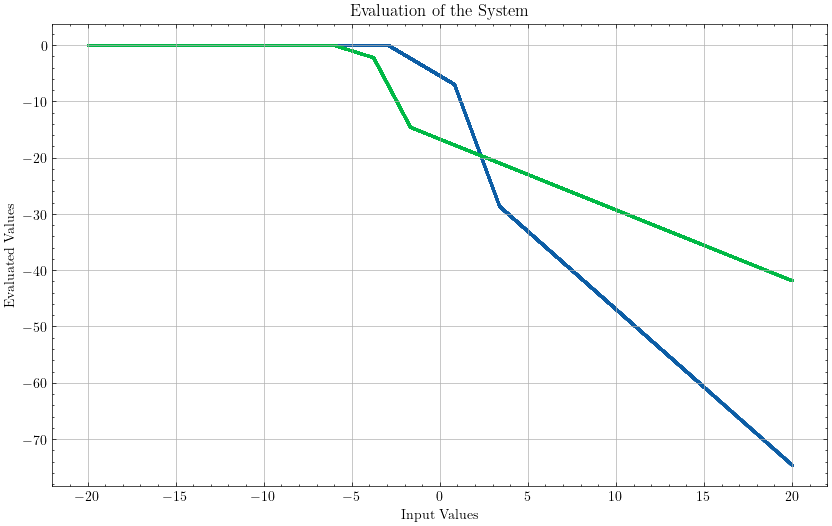

In [118]:
plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 0], evaluated_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System')
plt.grid(True)
plt.show()
plt.clf()
plt.close()

In [119]:
expanded_values = jnp.repeat(values, expected_number_of_nls, axis=1)
train_values = expanded_values[:train_size]
inbound_test = expanded_values[train_size:test_size + train_size]
outofbound_test = expanded_values[test_size + train_size:]

train_outputs, inbound_test_outputs = evaluated_values[:train_size], evaluated_values[train_size:test_size + train_size]
outofbound_test_outputs = evaluated_values[test_size + train_size:]

train_batches = create_batches(train_values, train_outputs, batch_size)
inbound_test_batches = create_batches(inbound_test, inbound_test_outputs, batch_size)
outofbound_test_batches = create_batches(outofbound_test, outofbound_test_outputs, batch_size)

In [120]:
print(train_values.shape, inbound_test.shape, outofbound_test.shape)
print(len(train_batches), len(inbound_test_batches), len(outofbound_test_batches))

(10000, 4) (2000, 4) (2000, 4)
312 62 62


In [121]:
vectors = jnp.concatenate((state.params['params']['custom_activation']['alpha'], state.params['params']['custom_activation']['gamma']), axis=0).T
print(vectors)

[[ 0.12276907  2.92488583  0.34537679  0.96275118 -1.578886    0.61702359]
 [-0.2252094   0.4680558   0.10812936 -0.06541845  0.03321974  0.36312817]
 [ 0.38253197  1.57146125 -0.37652606  0.25422953  0.65814884 -0.13209523]
 [-0.82370999 -0.15600592  1.33324478  0.32582048 -1.71640044  0.91196174]
 [-0.3156888  -0.99219712  2.93234027  0.93112832 -0.70830732  0.02361197]
 [ 1.0807859  -0.85953849  1.22455323  1.33328047 -1.07779475 -1.81990804]
 [ 0.50248155 -1.2013893   0.09037604  2.21554196  1.54028061  0.21843576]
 [ 1.9578911   0.42444241  0.72333086 -1.62690367 -0.3189048  -0.20327687]]


In [122]:
num_epochs = 201
start_time = time.time()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_x, batch_y in train_batches:

        state, loss = train_step(state, batch_x, batch_y)
        epoch_loss += loss

    if epoch % 2 == 0:
        inbound_test_loss = evaluate(state, inbound_test_batches)
        outofbound_test_loss = evaluate(state, outofbound_test_batches)
        print(f"Epoch {epoch}, Loss: {epoch_loss/len(train_batches)}, "
              f"Inbound Test Loss: {inbound_test_loss/len(inbound_test_batches)}, Out-of-bound Test Loss: {outofbound_test_loss/len(outofbound_test_batches)}")
        
print("Training complete!")

end_time = time.time()
total_duration = end_time - start_time
print(f"Total training time: {total_duration:.4f} seconds")

Epoch 0, Loss: 176.59931799594656, Inbound Test Loss: 0.9846769328609549, Out-of-bound Test Loss: 1.0373182400137557
Epoch 2, Loss: 28.87252900106277, Inbound Test Loss: 0.4243799215068186, Out-of-bound Test Loss: 1.046982759081303
Epoch 4, Loss: 21.866920517582408, Inbound Test Loss: 0.31366757140839946, Out-of-bound Test Loss: 0.7281250904125257
Epoch 6, Loss: 14.886076881988366, Inbound Test Loss: 0.2054455129593158, Out-of-bound Test Loss: 0.3913991115545105
Epoch 8, Loss: 8.843334126468609, Inbound Test Loss: 0.11787101483011785, Out-of-bound Test Loss: 0.12259050981826947
Epoch 10, Loss: 5.200612102662225, Inbound Test Loss: 0.07276057534902682, Out-of-bound Test Loss: 0.049580028285389585
Epoch 12, Loss: 3.6881986207238926, Inbound Test Loss: 0.054084199346870934, Out-of-bound Test Loss: 0.06989499923569482
Epoch 14, Loss: 2.820913119121882, Inbound Test Loss: 0.04204824865846628, Out-of-bound Test Loss: 0.06957315563365192
Epoch 16, Loss: 2.1611519549487337, Inbound Test Loss: 

In [123]:
vectors = jnp.concatenate((state.params['params']['custom_activation']['alpha'], state.params['params']['custom_activation']['gamma']), axis=0).T
print(vectors)

[[ 0.19010408  4.03103789  1.10495232 -0.80849417 -0.80850421 -0.80813361]
 [-1.38416597  1.88850184 -0.40090879  3.7948773   1.68704235  6.00159456]
 [ 0.45097539  1.9874815  -0.63141665  3.42220669  3.78622423 -3.36684944]
 [-1.10056871 -2.12964031  1.04087251 -3.36557947 -3.36913654  2.93062892]
 [-0.3156888  -0.99219712  2.93234027  0.93112832 -0.70830732  0.02361197]
 [ 1.0807859  -0.85953849  1.22455323  1.33328047 -1.07779475 -1.81990804]
 [ 0.50248155 -1.2013893   0.09037604  2.21554196  1.54028061  0.21843576]
 [ 1.9578911   0.42444241  0.72333086 -1.62690367 -0.3189048  -0.20327687]]


[Array(0, dtype=int64), Array(0, dtype=int64), Array(0, dtype=int64), Array(1, dtype=int64), Array(1, dtype=int64), Array(1, dtype=int64), Array(0, dtype=int64), Array(1, dtype=int64)]


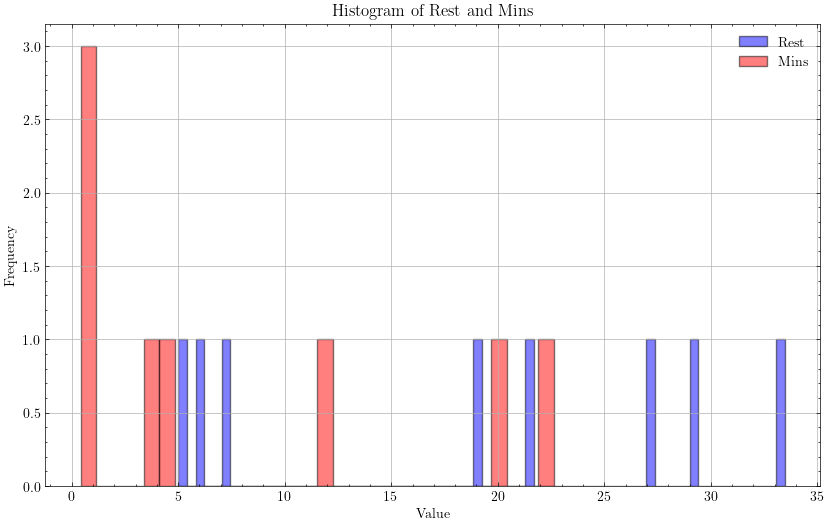

In [124]:
rest = []
mins = []
mins_nls = []

for vec in vectors:
    temp = []
    for nls in vec_nls:
        temp.append(jnp.abs(vec @ nls))
    
    min_value = jnp.min(jnp.array(temp))
    min_index = jnp.argmin(jnp.array(temp))  # Find the index of the minimum value
    
    mins.append(min_value)
    mins_nls.append(min_index)  # Store the `nls` corresponding to the minimum value
    
    # Remove the min value and associated nls
    temp.remove(min_value)
    rest.append(temp)
    
print(mins_nls)
    
plt.figure(figsize=(10, 6))
plt.hist([item for sublist in rest for item in sublist], bins=70, edgecolor='black', alpha=0.5, label='Rest', color='blue')
plt.hist(mins, bins=30, edgecolor='black', alpha=0.5, label='Mins', color='red')
plt.title('Histogram of Rest and Mins')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

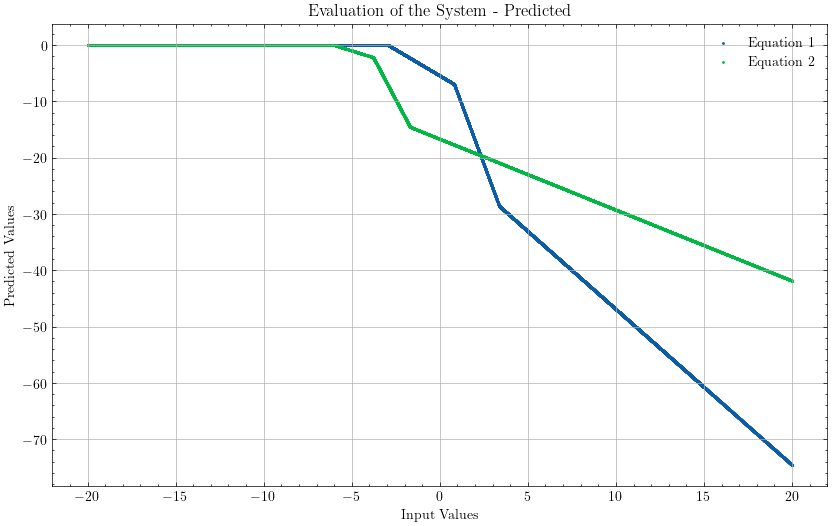

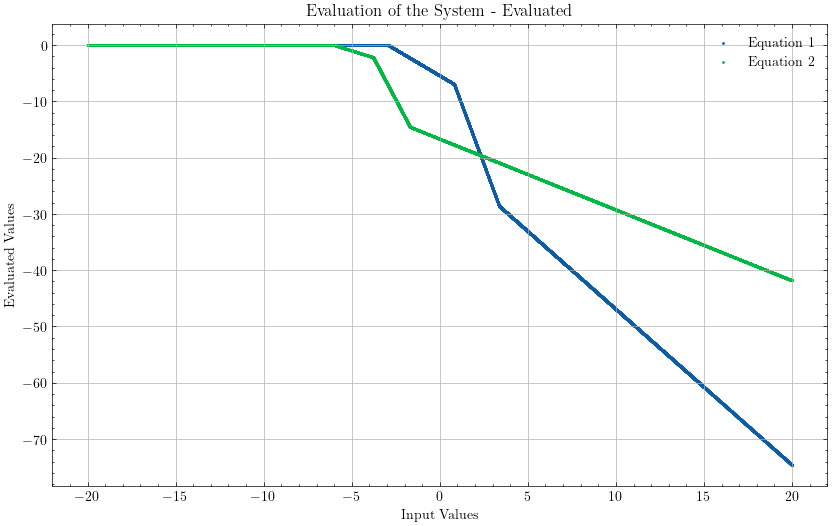

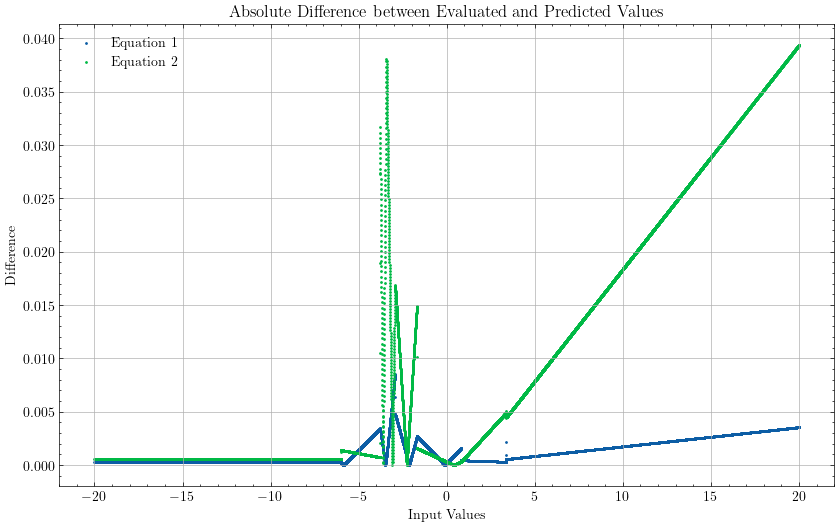

In [126]:
predicted_values = state.apply_fn(state.params, expanded_values)

plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], predicted_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Predicted Values')
plt.title('Evaluation of the System - Predicted')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], evaluated_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System - Evaluated')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], jnp.abs(evaluated_values[:, i] - predicted_values[:, i]), label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Difference')
plt.title('Absolute Difference between Evaluated and Predicted Values')
plt.grid(True)
plt.legend()
plt.show()

plt.clf()
plt.close()

In [128]:
print(state.params['params']['output_layer']['kernel'])

[[-1.2394158e+00 -1.9681145e-04]
 [-4.0976219e-03  2.4461875e+00]
 [-9.4957883e-03 -6.7625469e-01]
 [-1.7595494e+00  1.3228299e-01]]


### Uniform

In [135]:
system = Equations(**config)

In [136]:
# Split PRNG key
key, subkey = random.split(key)

# Generate new training values uniformly in [-bound, bound]
train_values = random.uniform(subkey, shape=(total_size, config['n_vars']), minval=-1 * bound, maxval=bound)

inbound_test = train_values[indices]  # Extract test points
train_values = train_values[mask]  # Remove them from training set

# Generate out-of-bound test values in [-bound-bound_delta, -bound] ∪ [bound, bound+bound_delta]
bound_delta = 5
key, subkey = random.split(key)
range1 = random.uniform(subkey, shape=(test_size//2, config['n_vars']), minval=-1*bound - bound_delta, maxval=-1*bound)
key, subkey = random.split(key)
range2 = random.uniform(subkey, shape=(test_size//2, config['n_vars']), minval=bound, maxval=bound + bound_delta)
outofbound_test = jnp.concatenate((range1, range2), axis=0)

# Stack both test sets
stacked_test = jnp.vstack((inbound_test, outofbound_test))

# Concatenate training and test values
values = jnp.vstack((train_values, stacked_test))

# Evaluate function on all values
evaluated_values = vmap(my_eval)(values)

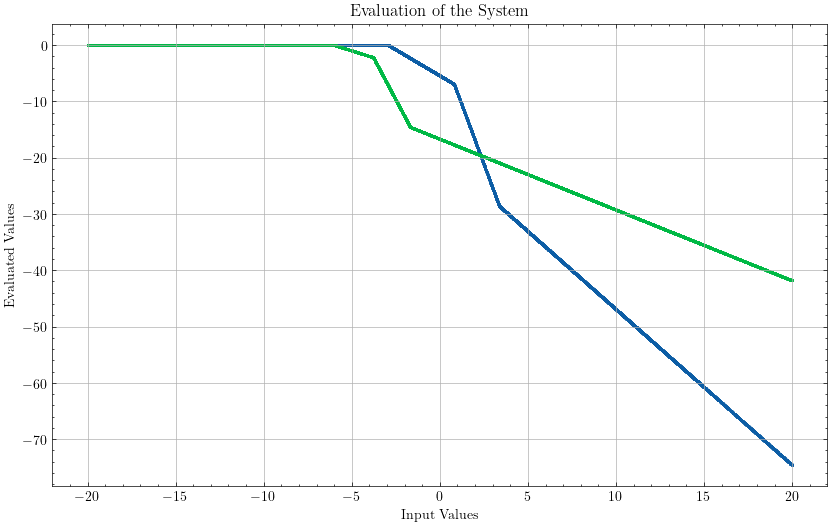

In [137]:
plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], evaluated_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System')
plt.grid(True)
plt.show()
plt.clf()
plt.close()

In [138]:
expanded_values = jnp.repeat(values, expected_number_of_nls, axis=1)
train_values = expanded_values[:train_size]
inbound_test = expanded_values[train_size:test_size + train_size]
outofbound_test = expanded_values[test_size + train_size:]

train_outputs, inbound_test_outputs = evaluated_values[:train_size], evaluated_values[train_size:test_size + train_size]
outofbound_test_outputs = evaluated_values[test_size + train_size:]

train_batches = create_batches(train_values, train_outputs, batch_size)
inbound_test_batches = create_batches(inbound_test, inbound_test_outputs, batch_size)
outofbound_test_batches = create_batches(outofbound_test, outofbound_test_outputs, batch_size)

In [139]:
key, subkey = random.split(key)
params = model.init(subkey, dummy_input)
state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

In [141]:
num_epochs = 201
start_time = time.time()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_x, batch_y in train_batches:

        state, loss = train_step(state, batch_x, batch_y)
        epoch_loss += loss

    if epoch % 2 == 0:
        inbound_test_loss = evaluate(state, inbound_test_batches)
        outofbound_test_loss = evaluate(state, outofbound_test_batches)
        print(f"Epoch {epoch}, Loss: {epoch_loss/len(train_batches)}, "
              f"Inbound Test Loss: {inbound_test_loss/len(inbound_test_batches)}, Out-of-bound Test Loss: {outofbound_test_loss/len(outofbound_test_batches)}")
        
print("Training complete!")

end_time = time.time()
total_duration = end_time - start_time
print(f"Total training time: {total_duration:.4f} seconds")

Epoch 0, Loss: 295.4043724734829, Inbound Test Loss: 2.1090920164643774, Out-of-bound Test Loss: 2.7570771096635216
Epoch 2, Loss: 29.928679044243616, Inbound Test Loss: 0.37646028408583715, Out-of-bound Test Loss: 1.1853378042057676
Epoch 4, Loss: 19.059661146359517, Inbound Test Loss: 0.2991292634441423, Out-of-bound Test Loss: 0.9374851702476472
Epoch 6, Loss: 16.687221704425486, Inbound Test Loss: 0.2613736283199314, Out-of-bound Test Loss: 0.7475874493431371
Epoch 8, Loss: 14.478360999865913, Inbound Test Loss: 0.22579009639715497, Out-of-bound Test Loss: 0.5777278886550296
Epoch 10, Loss: 12.474484357177024, Inbound Test Loss: 0.19378298251747966, Out-of-bound Test Loss: 0.429600818813016
Epoch 12, Loss: 10.698140686659812, Inbound Test Loss: 0.16536108056613344, Out-of-bound Test Loss: 0.3037302730626062
Epoch 14, Loss: 9.091702878429123, Inbound Test Loss: 0.13961198965284144, Out-of-bound Test Loss: 0.19771174677179845
Epoch 16, Loss: 7.619921480605926, Inbound Test Loss: 0.11

[Array(1, dtype=int64), Array(1, dtype=int64), Array(1, dtype=int64), Array(0, dtype=int64), Array(1, dtype=int64), Array(0, dtype=int64), Array(0, dtype=int64), Array(0, dtype=int64)]


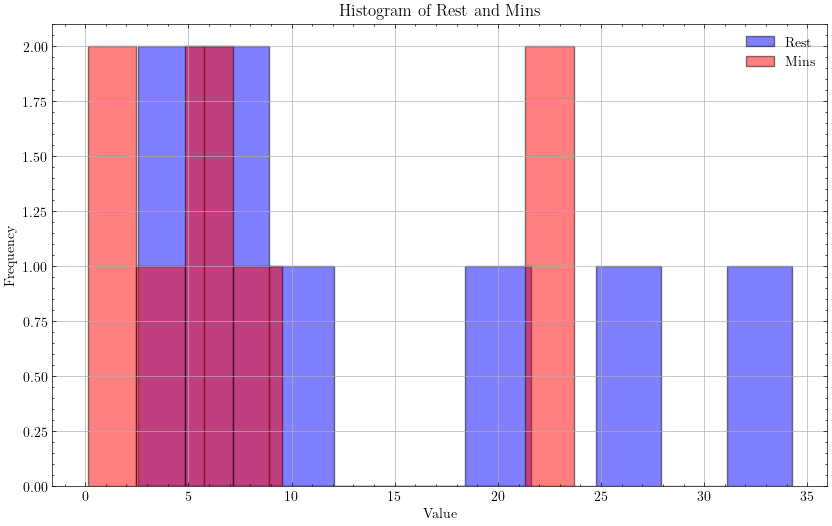

In [142]:
vectors = jnp.concatenate((state.params['params']['custom_activation']['alpha'], state.params['params']['custom_activation']['gamma']), axis=0).T

rest = []
mins = []
mins_nls = []

for vec in vectors:
    temp = []
    for nls in vec_nls:
        temp.append(jnp.abs(vec @ nls))
    
    min_value = jnp.min(jnp.array(temp))
    min_index = jnp.argmin(jnp.array(temp))  # Find the index of the minimum value
    
    mins.append(min_value)
    mins_nls.append(min_index)  # Store the `nls` corresponding to the minimum value
    
    # Remove the min value and associated nls
    temp.remove(min_value)
    rest.append(temp)
    
print(mins_nls)
    
plt.figure(figsize=(10, 6))
plt.hist([item for sublist in rest for item in sublist], bins=10, edgecolor='black', alpha=0.5, label='Rest', color='blue')
plt.hist(mins, bins=10, edgecolor='black', alpha=0.5, label='Mins', color='red')
plt.title('Histogram of Rest and Mins')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [143]:
print(vectors)
print(vec_nls)

[[ 0.11583397  1.22688955 -0.25689462 -0.33534403  0.0199694   0.18536215]
 [ 0.73344564  2.11158803 -1.18620572  0.07466371 -0.26447793 -0.34208337]
 [-3.21231823 -0.9018803   2.76790679 -0.80828186  2.93273795 -3.36794272]
 [-2.32096726  2.18074384  0.77795277  1.67534221  3.69981499  5.4822053 ]
 [ 0.31227938  1.32705568  1.69648348  0.16505553 -0.23108921  1.05512464]
 [ 0.46604577 -0.41456168  1.39779505 -0.58489026  0.19468778  0.76876917]
 [ 0.26777031 -0.58285998  0.24099322  0.293147    0.44239495 -0.07006345]
 [ 0.52404358  0.05777413 -0.64613596  1.523237    1.07360406 -0.45767611]]
[[-1.85333055 -6.60290317  5.68947106  2.93265932 -0.8081216  -3.36796725]
 [ 4.64605079 -4.92323169 -0.98039673  1.68994228  3.78551475  6.00239929]]


In [163]:
jnp.abs((evaluated_values[0, 1] - predicted_values[0, 1])) / evaluated_values[0, 1]

Array(-0.00048911, dtype=float64)

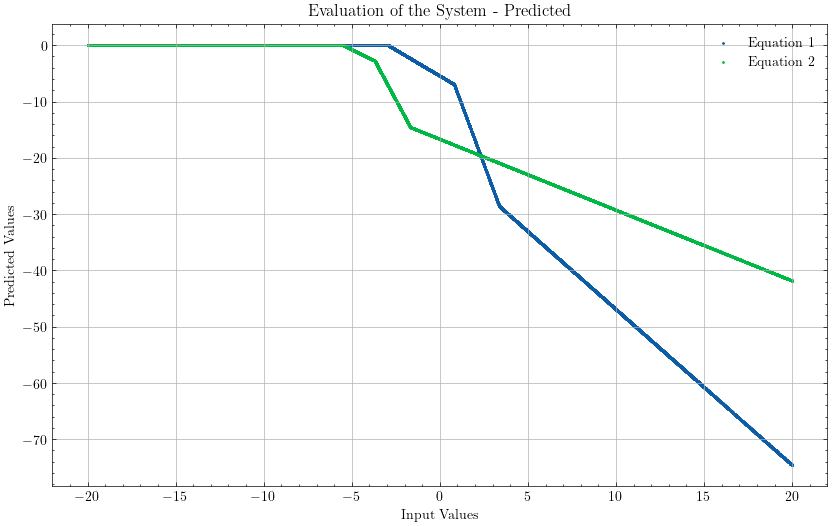

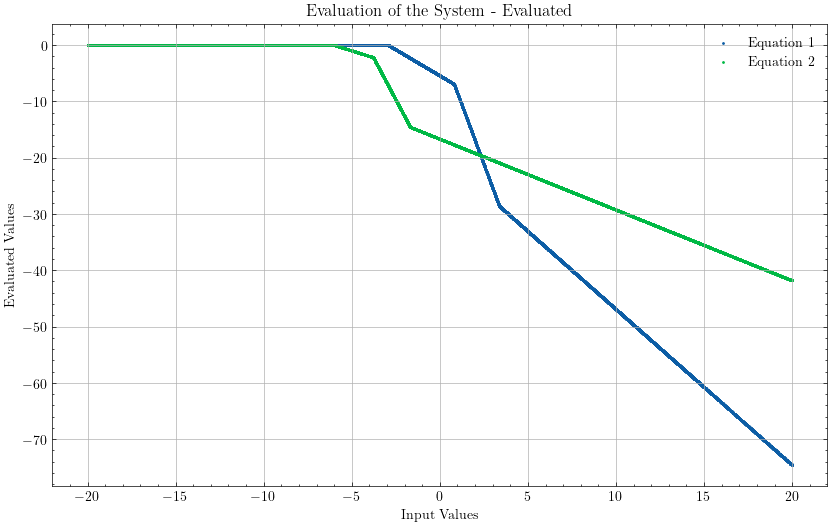

[-51.00252107   0.         -36.25374005 ... -64.11607382 -71.67901805
 -64.21623461]
[-5.09959845e+01 -3.78671588e-03 -3.62498747e+01 ... -6.41129947e+01
 -7.16753958e+01 -6.42125626e+01]
[1.28162387e-04 3.78671588e+04 1.06620219e-04 ... 4.80240012e-05
 5.05339034e-05 5.71818828e-05]
[-31.09753953  -1.56148091 -24.39377074 ... -37.05804741 -40.49563519
 -37.10357353]
[-31.11274963  -1.64951448 -24.39853154 ... -37.05779865 -40.49962227
 -37.10771295]
[4.89109375e-04 5.63782567e-02 1.95164235e-04 ... 6.71282716e-06
 9.84569552e-05 1.11563820e-04]


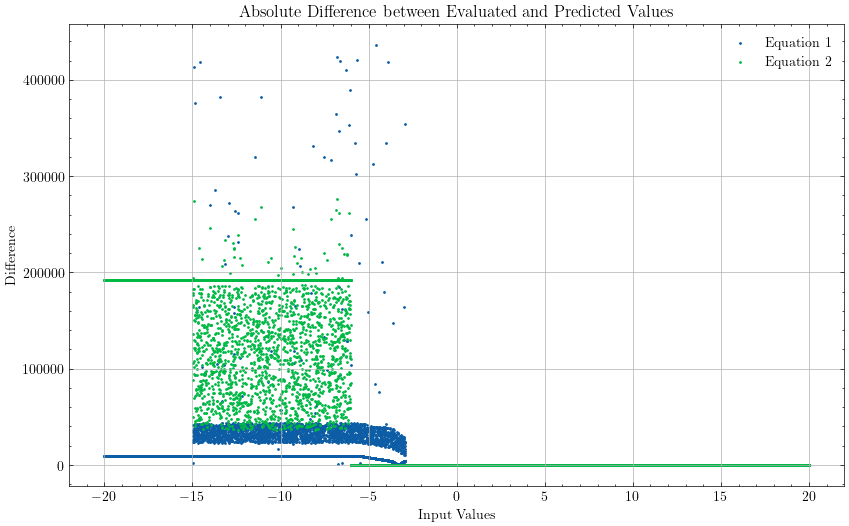

In [ ]:
predicted_values = state.apply_fn(state.params, expanded_values)

plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], predicted_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Predicted Values')
plt.title('Evaluation of the System - Predicted')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], evaluated_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System - Evaluated')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 1], jnp.abs((evaluated_values[:, i] - predicted_values[:, i])/(jnp.abs(evaluated_values[:,i])+1e-7)), label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Difference')
plt.title('Absolute Difference between Evaluated and Predicted Values')
plt.grid(True)
plt.legend()
plt.show()

plt.clf()
plt.close()

In [27]:
print(jnp.where(state.params['params']['hidden_layer']['kernel'] > 0.5, 1, 0))
print(jnp.where(state.params['params']['output_layer']['kernel'] > 0.5, 1, 0))

print(state.params['params']['hidden_layer']['kernel'])
print(state.params['params']['output_layer']['kernel'])


[[0 0 0 0]
 [0 0 1 0]]
[[0 0]
 [0 0]
 [0 0]
 [1 0]]
[[ 2.8294715e-05 -5.6729448e-04 -1.2759362e-04 -8.5917086e-04]
 [ 3.8657066e-01 -1.0511256e+00  1.5593222e+00 -1.0283506e+00]]
[[-0.11259968 -1.6038646 ]
 [-0.67197657 -0.055755  ]
 [-0.21043229  0.10006594]
 [ 0.66127306 -0.21708882]]


### Fixed Activation

In [ ]:
model = FixedNN(N=input_dim, L=2, output_dim=input_dim, activations=non_lins)


dummy_input = jnp.zeros((batch_size, input_dim))
key = random.key(seed)
key, subkey = random.split(key)
params = model.init(subkey, dummy_input)
optimizer = adam(learning_rate=0.001)
state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

In [ ]:
system = Equations(**config)

In [ ]:
key, subkey = random.split(key)
del(values, evaluated_values, test_values)
values = random.uniform(key, shape=(num_samples, config['n_vars']), minval=-10, maxval=10)
range1 = random.uniform(key, shape=(test_size, config['n_vars']), minval=-15, maxval=-10)
range2 = random.uniform(key, shape=(test_size, config['n_vars']), minval=10, maxval=15)
test_values = jnp.concatenate((range1, range2), axis=0)
values = jnp.concatenate((values, test_values), axis=0)

evaluated_values = []
evaluated_values = vmap(my_eval)(values)

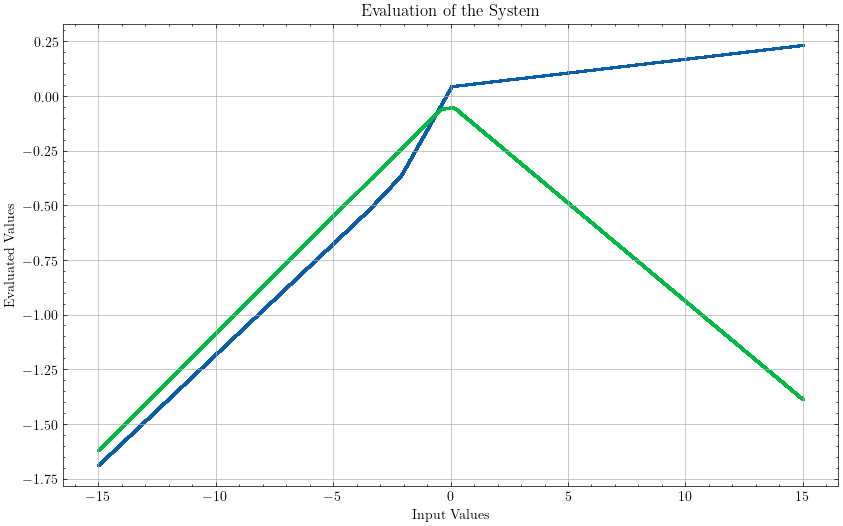

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 0], evaluated_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System')
plt.grid(True)
plt.show()
plt.clf()
plt.close()

In [ ]:
test_size = int(0.2 * num_samples)

train_inputs, test_inputs = values[:num_samples], values[num_samples:]
train_outputs, test_outputs = evaluated_values[:num_samples], evaluated_values[num_samples:]

train_batches = create_batches(train_inputs, train_outputs, batch_size)
test_batches = create_batches(test_inputs, test_outputs, batch_size)

In [ ]:
key, subkey = random.split(key)
params = model.init(subkey, dummy_input)
state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

In [ ]:
num_epochs = 201
start_time = time.time()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_x, batch_y in train_batches:
        state, loss = train_step(state, batch_x, batch_y)
        epoch_loss += loss

    if epoch % 2 == 0:
        test_loss = evaluate(state, test_batches)
        print(f"Epoch {epoch}, Loss: {epoch_loss/len(train_batches)}, Test Loss: {test_loss/len(test_batches)}")
        
print("Training complete!")

end_time = time.time()
total_duration = end_time - start_time
print(f"Total training time: {total_duration:.4f} seconds")

Epoch 0, Loss: 0.03893287852406502, Test Loss: 1.841471384977922e-05
Epoch 2, Loss: 0.0004781458410434425, Test Loss: 2.0915877030347474e-06
Epoch 4, Loss: 0.00010328119969926775, Test Loss: 4.3495799673110014e-07
Epoch 6, Loss: 6.317443330772221e-05, Test Loss: 2.9323305739126226e-07
Epoch 8, Loss: 5.197630889597349e-05, Test Loss: 2.5616020593588473e-07
Epoch 10, Loss: 4.193700078758411e-05, Test Loss: 3.939936448205117e-07
Epoch 12, Loss: 3.6535344406729564e-05, Test Loss: 3.5813340559798235e-07
Epoch 14, Loss: 3.0791157769272104e-05, Test Loss: 3.277906444054679e-07
Epoch 16, Loss: 2.552544538048096e-05, Test Loss: 3.069883121042949e-07
Epoch 18, Loss: 2.190201666962821e-05, Test Loss: 3.16472920758315e-07
Epoch 20, Loss: 1.971254459931515e-05, Test Loss: 3.013824994013703e-07
Epoch 22, Loss: 1.846458326326683e-05, Test Loss: 2.964601151234092e-07
Epoch 24, Loss: 1.7805603420129046e-05, Test Loss: 2.880954070860753e-07
Epoch 26, Loss: 1.744356814015191e-05, Test Loss: 2.78114384855

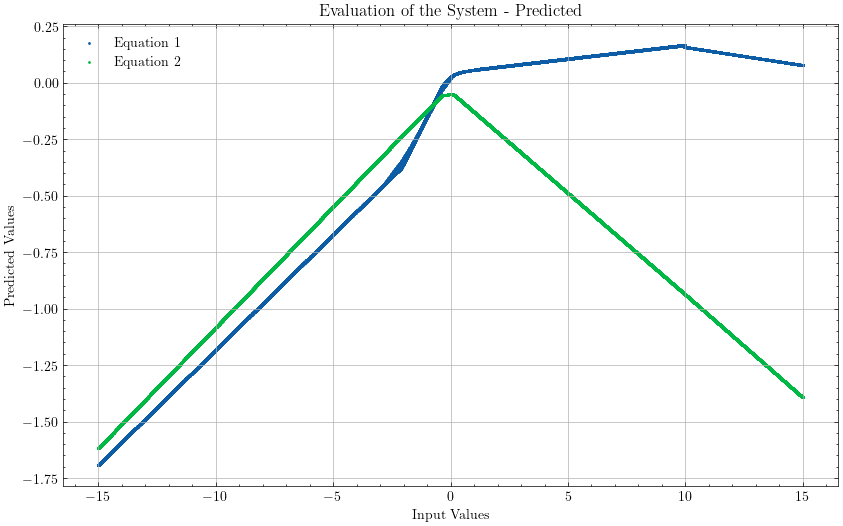

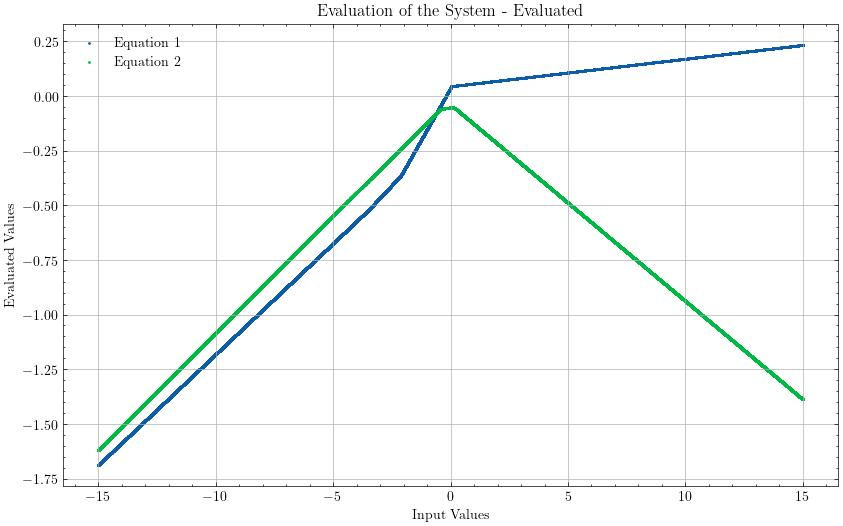

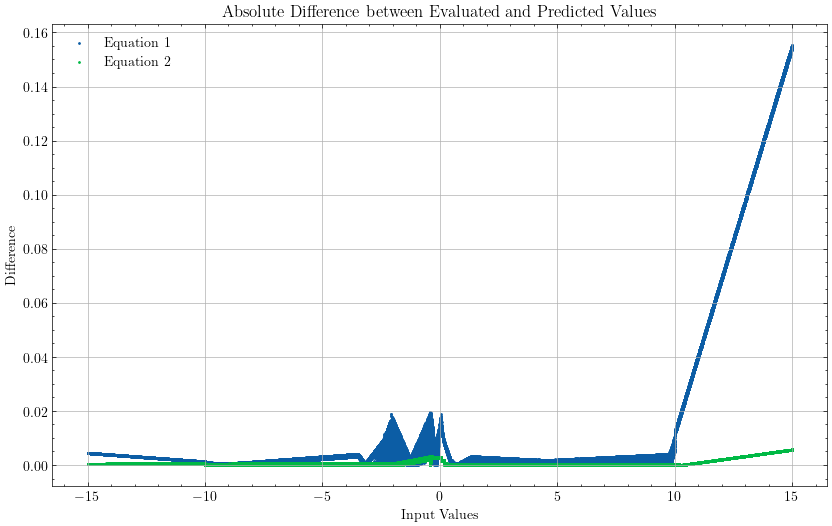

In [ ]:
predicted_values = state.apply_fn(state.params, values)

plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 0], predicted_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Predicted Values')
plt.title('Evaluation of the System - Predicted')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 0], evaluated_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System - Evaluated')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 0], jnp.abs(evaluated_values[:, i] - predicted_values[:, i]), label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Difference')
plt.title('Absolute Difference between Evaluated and Predicted Values')
plt.grid(True)
plt.legend()
plt.show()

plt.clf()
plt.close()

### Binary Network

In [26]:
model = FixedNN(N=input_dim, L=2, output_dim=input_dim, activations=non_lins)


dummy_input = jnp.zeros((batch_size, input_dim))
key = random.key(seed)
key, subkey = random.split(key)
params = model.init(subkey, dummy_input)
optimizer = adam(learning_rate=0.001)
state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

In [27]:
system = Equations(**config)

In [28]:
key, subkey = random.split(key)
del(values, evaluated_values, test_values)
values = random.uniform(key, shape=(num_samples, config['n_vars']), minval=-10, maxval=10)
range1 = random.uniform(key, shape=(test_size, config['n_vars']), minval=-15, maxval=-10)
range2 = random.uniform(key, shape=(test_size, config['n_vars']), minval=10, maxval=15)
test_values = jnp.concatenate((range1, range2), axis=0)
values = jnp.concatenate((values, test_values), axis=0)

evaluated_values = []
evaluated_values = vmap(my_eval)(values)

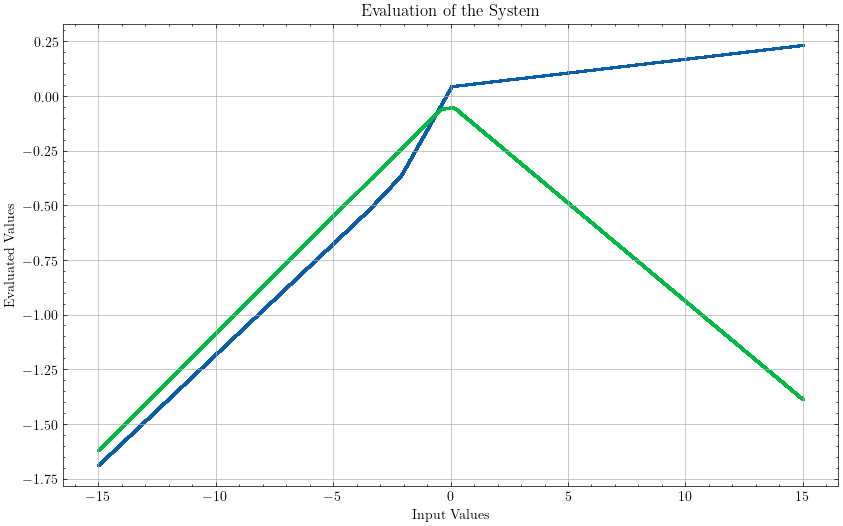

In [29]:
plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 0], evaluated_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System')
plt.grid(True)
plt.show()
plt.clf()
plt.close()

In [30]:
test_size = int(0.2 * num_samples)

train_inputs, test_inputs = values[:num_samples], values[num_samples:]
train_outputs, test_outputs = evaluated_values[:num_samples], evaluated_values[num_samples:]

train_batches = create_batches(train_inputs, train_outputs, batch_size)
test_batches = create_batches(test_inputs, test_outputs, batch_size)

In [31]:
key, subkey = random.split(key)
params = model.init(subkey, dummy_input)
state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

In [32]:
num_epochs = 201
start_time = time.time()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_x, batch_y in train_batches:
        state, loss = train_step(state, batch_x, batch_y)
        epoch_loss += loss

    if epoch % 2 == 0:
        test_loss = evaluate(state, test_batches)
        print(f"Epoch {epoch}, Loss: {epoch_loss/len(train_batches)}, Test Loss: {test_loss/len(test_batches)}")
        
print("Training complete!")

end_time = time.time()
total_duration = end_time - start_time
print(f"Total training time: {total_duration:.4f} seconds")

Epoch 0, Loss: 0.03893287852406502, Test Loss: 1.841471384977922e-05
Epoch 2, Loss: 0.0004781458410434425, Test Loss: 2.0915877030347474e-06
Epoch 4, Loss: 0.00010328119969926775, Test Loss: 4.3495799673110014e-07
Epoch 6, Loss: 6.317443330772221e-05, Test Loss: 2.9323305739126226e-07
Epoch 8, Loss: 5.197630889597349e-05, Test Loss: 2.5616020593588473e-07
Epoch 10, Loss: 4.193700078758411e-05, Test Loss: 3.939936448205117e-07
Epoch 12, Loss: 3.6535344406729564e-05, Test Loss: 3.5813340559798235e-07
Epoch 14, Loss: 3.0791157769272104e-05, Test Loss: 3.277906444054679e-07
Epoch 16, Loss: 2.552544538048096e-05, Test Loss: 3.069883121042949e-07
Epoch 18, Loss: 2.190201666962821e-05, Test Loss: 3.16472920758315e-07
Epoch 20, Loss: 1.971254459931515e-05, Test Loss: 3.013824994013703e-07
Epoch 22, Loss: 1.846458326326683e-05, Test Loss: 2.964601151234092e-07
Epoch 24, Loss: 1.7805603420129046e-05, Test Loss: 2.880954070860753e-07
Epoch 26, Loss: 1.744356814015191e-05, Test Loss: 2.78114384855

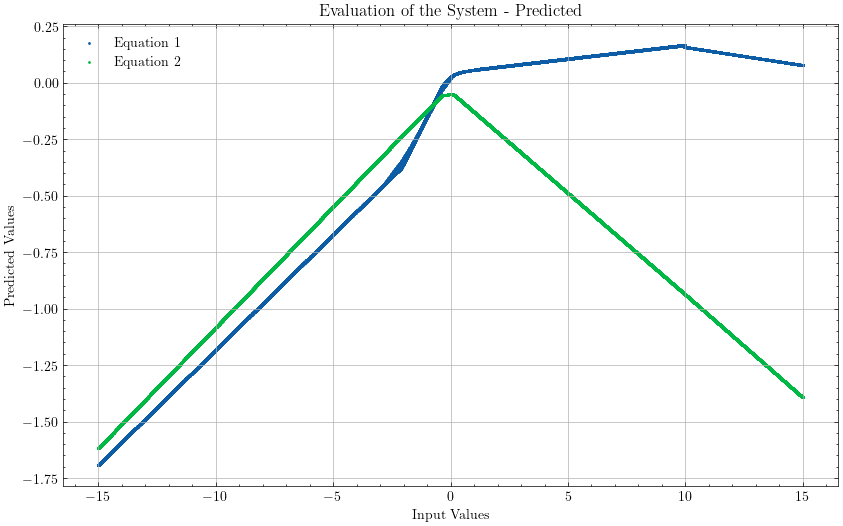

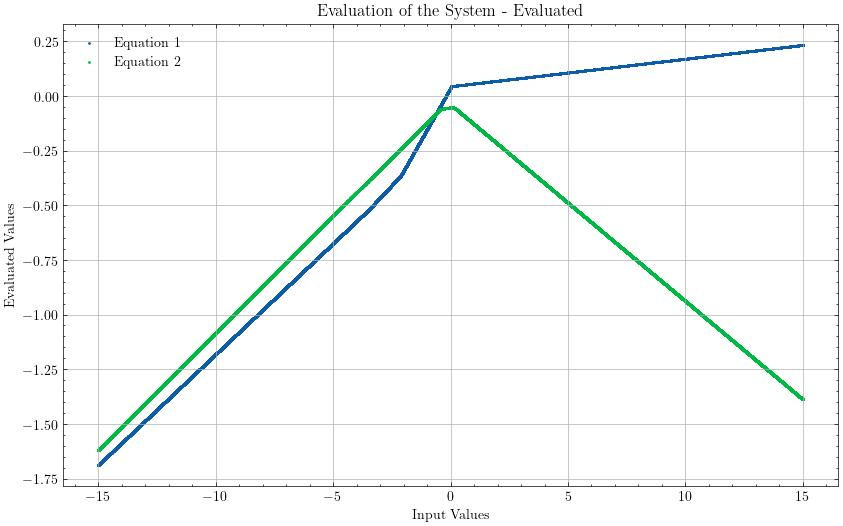

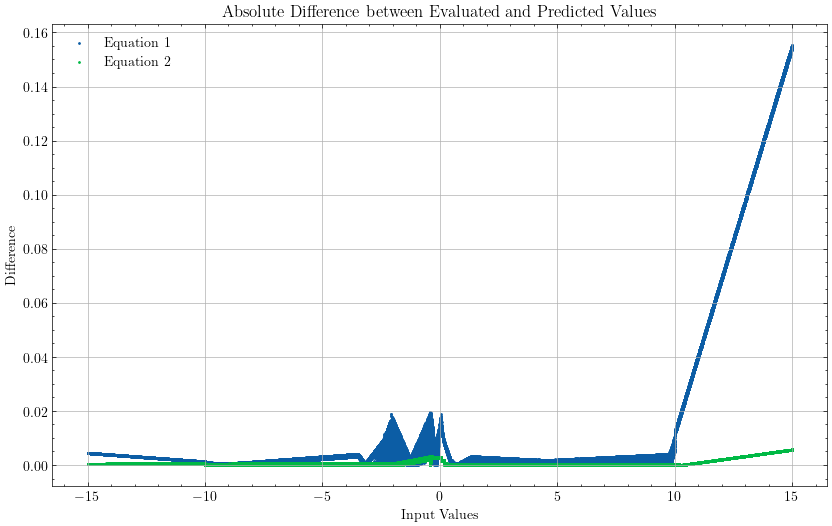

In [34]:
predicted_values = state.apply_fn(state.params, values)

plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 0], predicted_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Predicted Values')
plt.title('Evaluation of the System - Predicted')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 0], evaluated_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System - Evaluated')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 0], jnp.abs(evaluated_values[:, i] - predicted_values[:, i]), label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Difference')
plt.title('Absolute Difference between Evaluated and Predicted Values')
plt.grid(True)
plt.legend()
plt.show()

plt.clf()
plt.close()

## Test with unsupervised process

In [ ]:
input_dim = 10
output_dim = input_dim
model = NoHiddenLayerNN(output_dim=output_dim, input_dim=input_dim)
#seed = 42
seed = 34
num_samples = int(5e4)
batch_size = 32


dummy_input = jnp.zeros((batch_size, input_dim))
key = random.key(seed)
key, subkey = random.split(key)
params = model.init(subkey, dummy_input)
optimizer = adam(learning_rate=0.001)
state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

In [ ]:
def generate_alphabeta(dim, num, seed):

    key = random.key(seed)
    shape = (dim, num)
    A = random.normal(key, shape)
    Q, _ = jnp.linalg.qr(A)
    return Q

def generate_callable_functions(dim, num, seed):

    bases = generate_alphabeta(dim, num, seed)  # Get num basis vectors
    
    alphas = bases[:dim//3, :].T  # First half of Q are alphas
    betas = bases[dim//3:2*dim//3, :].T   # Second half of Q are betas
    gammas = bases[2*dim//3:, :].T

    def make_function(alpha, beta, gamma, base):
        @jit
        def func(x):
            return (alpha[0] * nn.relu(beta[0] * x + gamma[0]) +
                    alpha[1] * nn.relu(beta[1] * x + gamma[1]) +
                    alpha[2] * nn.relu(beta[2] * x + gamma[2]))
        return func
    
    return tuple([make_function(alphas[i], betas[i], gammas[i], bases[:, i]) for i in range(num)]), bases.T

In [ ]:
dims = 9
n_nls = 20
alphabeta = generate_alphabeta(dims, n_nls, seed)
non_lins, vec_nls = generate_callable_functions(dims, n_nls, seed)

config = {
    "n_vars": 100,
    "n_eqs": 100,
    "bounds_addends": (1, 3),
    "bounds_multiplicands": (1, 1),
    "non_lins": non_lins,
    "sym_non_lins": None,
    "distribution": "uniform",
    "a": None,
    "b": None,
    "sigma": None,
    "p": None,
    "seed": seed
}

In [ ]:
print(non_lins, vec_nls)

(<PjitFunction of <function generate_callable_functions.<locals>.make_function.<locals>.func at 0x318490a40>>, <PjitFunction of <function generate_callable_functions.<locals>.make_function.<locals>.func at 0x3184911c0>>, <PjitFunction of <function generate_callable_functions.<locals>.make_function.<locals>.func at 0x318491760>>, <PjitFunction of <function generate_callable_functions.<locals>.make_function.<locals>.func at 0x318491e40>>, <PjitFunction of <function generate_callable_functions.<locals>.make_function.<locals>.func at 0x318492ca0>>, <PjitFunction of <function generate_callable_functions.<locals>.make_function.<locals>.func at 0x318493240>>, <PjitFunction of <function generate_callable_functions.<locals>.make_function.<locals>.func at 0x3184937e0>>, <PjitFunction of <function generate_callable_functions.<locals>.make_function.<locals>.func at 0x318493d80>>, <PjitFunction of <function generate_callable_functions.<locals>.make_function.<locals>.func at 0x318430360>>, <PjitFunc

In [ ]:
save_dir = "Data"
filename = "Test"

system = Equations(**config)
system.save_symb_expr(filename=os.path.join(save_dir, filename+'_symbolic.pdf'))

PDF already exists


### Linspace

In [ ]:
def eval(v):
    return system(y=v)

In [ ]:
values = jnp.tile(jnp.linspace(-10, 10, num_samples).reshape(-1, 1), (1, config['n_eqs']))

evaluated_values = []
evaluated_values = vmap(eval)(values)

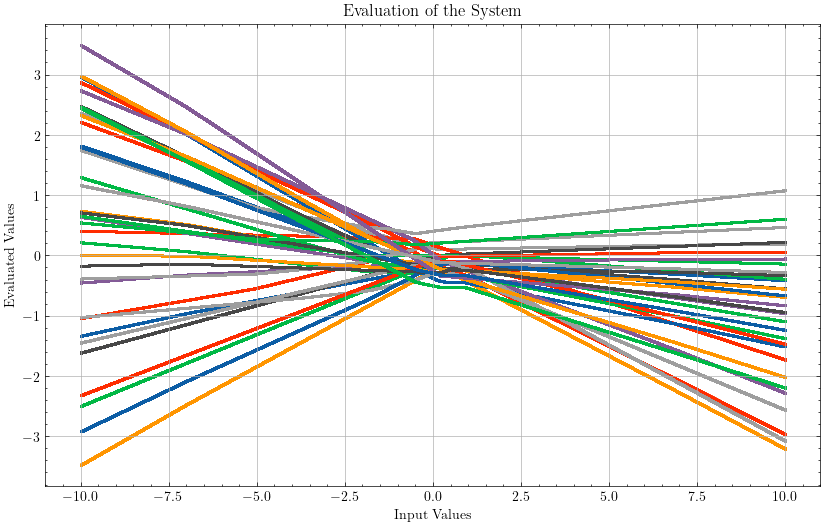

In [ ]:
plt.style.use('science')

plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 0], evaluated_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System')
plt.grid(True)
plt.show()
plt.clf()
plt.close()

In [ ]:
test_size = int(0.2 * num_samples)

train_inputs, test_inputs = values[:num_samples-test_size], values[num_samples-test_size:]
train_outputs, test_outputs = evaluated_values[:num_samples-test_size], evaluated_values[num_samples-test_size:]

train_batches = create_batches(train_inputs, train_outputs, batch_size)
test_batches = create_batches(test_inputs, test_outputs, batch_size)

In [ ]:
num_epochs = 201
start_time = time.time()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_x, batch_y in train_batches:
        state, loss = train_step(state, batch_x, batch_y)
        epoch_loss += loss

    if epoch % 2 == 0:
        test_loss = evaluate(state, test_batches)
        print(f"Epoch {epoch}, Loss: {epoch_loss/len(train_batches)}, Test Loss: {test_loss}")
        
print("Training complete!")

end_time = time.time()
total_duration = end_time - start_time
print(f"Total training time: {total_duration:.4f} seconds")

Epoch 0, Loss: 0.028887005522847176, Test Loss: 0.02261797897517681
Epoch 2, Loss: 2.3220407456392422e-05, Test Loss: 0.02010340243577957
Epoch 4, Loss: 1.826858897402417e-05, Test Loss: 0.0178254134953022
Epoch 6, Loss: 1.7886697605717927e-05, Test Loss: 0.018592914566397667
Epoch 8, Loss: 1.735898149490822e-05, Test Loss: 0.01822291687130928
Epoch 10, Loss: 1.822341619117651e-05, Test Loss: 0.020322274416685104
Epoch 12, Loss: 1.693875492492225e-05, Test Loss: 0.018484212458133698
Epoch 14, Loss: 1.5727411664556712e-05, Test Loss: 0.017672553658485413
Epoch 16, Loss: 1.4728394489793573e-05, Test Loss: 0.01579330489039421
Epoch 18, Loss: 1.3627924090542365e-05, Test Loss: 0.015227415598928928
Epoch 20, Loss: 1.2410514500516001e-05, Test Loss: 0.014721076004207134
Epoch 22, Loss: 1.000457450572867e-05, Test Loss: 0.016788363456726074
Epoch 24, Loss: 7.897670911916066e-06, Test Loss: 0.015966923907399178
Epoch 26, Loss: 6.1929813455208205e-06, Test Loss: 0.015146293677389622
Epoch 28, L

In [ ]:
vectors = jnp.concatenate((state.params['params']['alpha'], state.params['params']['beta'], state.params['params']['gamma']), axis=0).T
print(vectors)
for i in range(len(vectors)): 
    for j in range(i + 1, len(vectors)): 
        dot_product = jnp.dot(vectors[i], vectors[j]) 
        print(dot_product)

[[ 1.11342967e+00 -8.06009114e-01 -1.37307346e-01  2.79015779e-01
   7.22060025e-01  5.17993629e-01  1.95172548e+00  7.71561027e-01
   5.60034156e-01]
 [-3.72221082e-01  1.01134193e+00  2.91559193e-03  9.88818407e-01
  -2.34072611e-01  2.19571948e-01 -6.55627251e-01  1.43150485e+00
  -1.34459352e+00]
 [-1.24398792e+00  1.19550395e+00 -1.42559981e+00  5.65128267e-01
   9.03748512e-01  5.69588304e-01 -3.71484756e-01  9.66005802e-01
  -1.25353262e-01]
 [-1.26275826e+00  4.64225978e-01  3.88286054e-01  7.28687465e-01
   1.05414331e+00  1.10860777e+00 -1.08337387e-01 -2.49873430e-01
  -5.09731360e-02]
 [ 4.67648208e-01 -9.31645751e-01 -4.03215379e-01  1.31411469e+00
   4.30809408e-01  5.30682147e-01 -2.92602628e-01 -5.28916493e-02
  -2.24504650e-01]
 [-9.73136008e-01 -3.20339382e-01  1.18891275e+00  9.18530047e-01
   6.90845788e-01  9.36679363e-01 -9.86843050e-01 -9.11089480e-01
  -1.04577267e+00]
 [-2.05765739e-01  4.71420258e-01  7.79109225e-02  9.52379942e-01
   4.13688987e-01  1.5964596

In [ ]:
def find_optimal_clusters(vectors, max_k=10):
    iters = range(1, max_k + 1)
    sse = []
    for k in iters:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(vectors)
        sse.append(kmeans.inertia_)
    
    # Plot the SSE for each k
    plt.figure(figsize=(10, 6))
    plt.plot(iters, sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()
    
    # Find the elbow point using the KneeLocator from kneed library
    kneedle = KneeLocator(iters, sse, curve='convex', direction='decreasing')
    optimal_k = kneedle.elbow
    print(f"Optimal number of clusters: {optimal_k}")
    
    return optimal_k




def apply_kmeans(vectors, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(vectors)
    return kmeans.cluster_centers_, kmeans.labels_

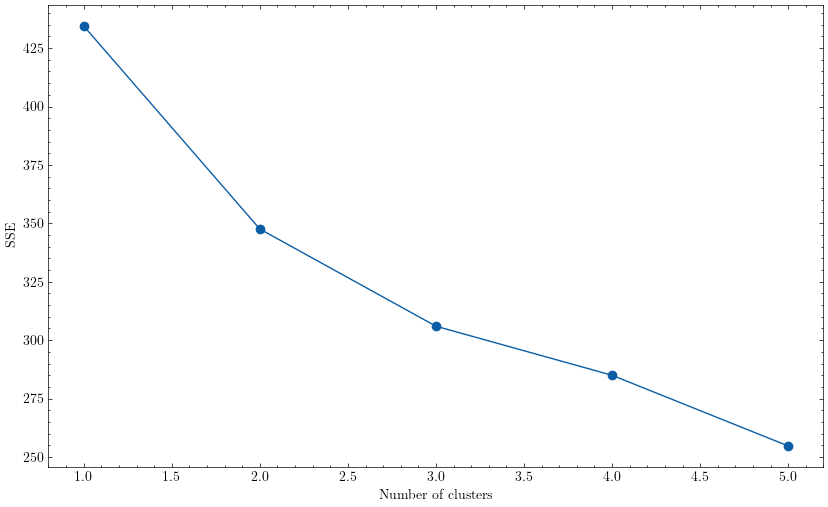

Optimal number of clusters: None


AttributeError: 'NoneType' object has no attribute 'item'

In [ ]:
optimal_k = find_optimal_clusters(vectors, max_k=5)

# Apply KMeans clustering with the optimal number of clusters
cluster_centers, labels = apply_kmeans(vectors, optimal_k.item())

# Print the cluster centers
print("Cluster Centers:")
print(cluster_centers)

In [ ]:
norm_alphas = state.params['params']['alpha'] * state.params['params']['beta']
norm_betas = state.params['params']['beta'] / state.params['params']['beta']
norm_gammas = state.params['params']['gamma'] / state.params['params']['beta']

vectors = jnp.concatenate((state.params['params']['alpha'], state.params['params']['beta'], state.params['params']['gamma']), axis=0).T
print(vectors)
for i in range(len(vectors)): 
    for j in range(i + 1, len(vectors)): 
        dot_product = jnp.dot(vectors[i], vectors[j]) 
        print(dot_product)

[[ 1.11342967e+00 -8.06009114e-01 -1.37307346e-01  2.79015779e-01
   7.22060025e-01  5.17993629e-01  1.95172548e+00  7.71561027e-01
   5.60034156e-01]
 [-3.72221082e-01  1.01134193e+00  2.91559193e-03  9.88818407e-01
  -2.34072611e-01  2.19571948e-01 -6.55627251e-01  1.43150485e+00
  -1.34459352e+00]
 [-1.24398792e+00  1.19550395e+00 -1.42559981e+00  5.65128267e-01
   9.03748512e-01  5.69588304e-01 -3.71484756e-01  9.66005802e-01
  -1.25353262e-01]
 [-1.26275826e+00  4.64225978e-01  3.88286054e-01  7.28687465e-01
   1.05414331e+00  1.10860777e+00 -1.08337387e-01 -2.49873430e-01
  -5.09731360e-02]
 [ 4.67648208e-01 -9.31645751e-01 -4.03215379e-01  1.31411469e+00
   4.30809408e-01  5.30682147e-01 -2.92602628e-01 -5.28916493e-02
  -2.24504650e-01]
 [-9.73136008e-01 -3.20339382e-01  1.18891275e+00  9.18530047e-01
   6.90845788e-01  9.36679363e-01 -9.86843050e-01 -9.11089480e-01
  -1.04577267e+00]
 [-2.05765739e-01  4.71420258e-01  7.79109225e-02  9.52379942e-01
   4.13688987e-01  1.5964596

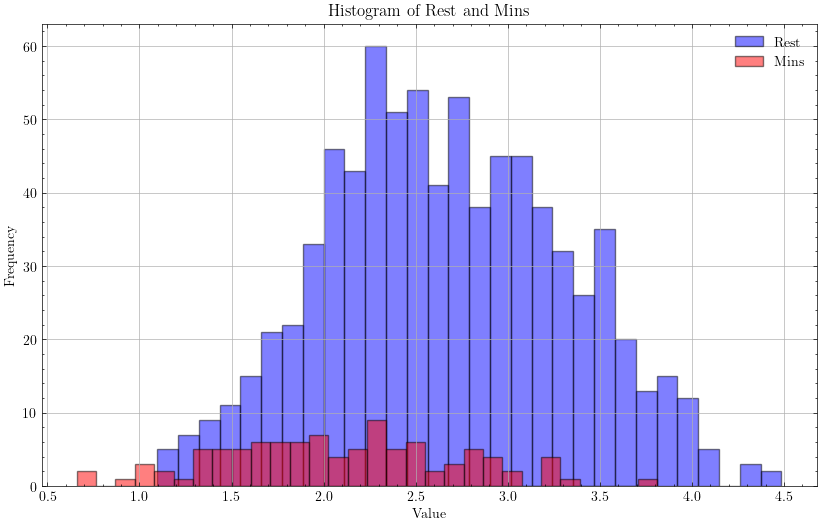

In [ ]:
rest = []
mins = []
for vec in vectors:
    temp = []
    for nls in vec_nls:
        temp.append(jnp.linalg.norm(vec - nls))
    
    mins.append(jnp.min(jnp.array(temp)))
    temp.remove(jnp.min(jnp.array(temp)))
    rest.append(temp)
    
    
plt.figure(figsize=(10, 6))
plt.hist([item for sublist in rest for item in sublist], bins=30, edgecolor='black', alpha=0.5, label='Rest', color='blue')
plt.hist(mins, bins=30, edgecolor='black', alpha=0.5, label='Mins', color='red')
plt.title('Histogram of Rest and Mins')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


### Uniform

In [ ]:
system = Equations(**config)

In [ ]:
key, subkey = random.split(key)
del(values)
values = random.uniform(key, shape=(num_samples, config['n_vars']), minval=-10, maxval=10)

del(evaluated_values)
evaluated_values = []
evaluated_values = vmap(eval)(values)

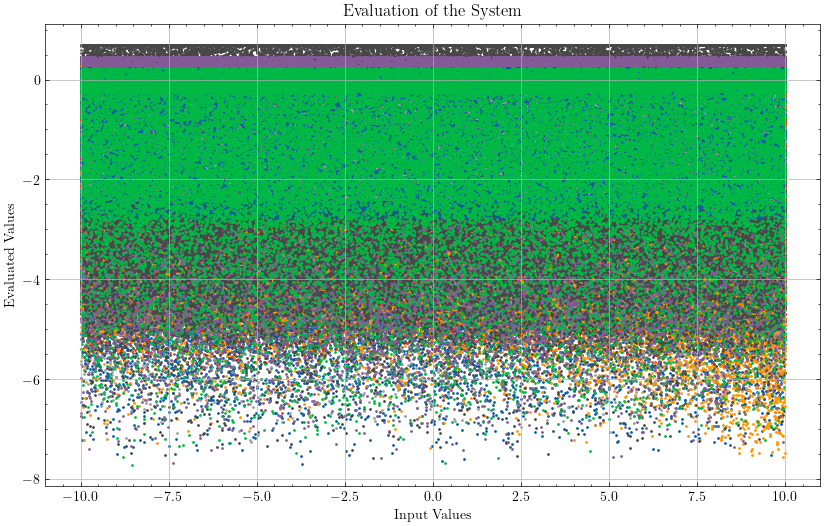

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(config['n_eqs']):
    plt.scatter(values[:, 0], evaluated_values[:, i], label=f'Equation {i+1}', s=1)
plt.xlabel('Input Values')
plt.ylabel('Evaluated Values')
plt.title('Evaluation of the System')
plt.grid(True)
plt.show()
plt.clf()
plt.close()

In [ ]:
test_size = int(0.2 * num_samples)

train_inputs, test_inputs = values[:num_samples-test_size], values[num_samples-test_size:]
train_outputs, test_outputs = evaluated_values[:num_samples-test_size], evaluated_values[num_samples-test_size:]

train_batches = create_batches(train_inputs, train_outputs, batch_size)
test_batches = create_batches(test_inputs, test_outputs, batch_size)

In [ ]:
key, subkey = random.split(key)
params = model.init(subkey, dummy_input)
state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

In [ ]:
num_epochs = 201
start_time = time.time()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_x, batch_y in train_batches:
        state, loss = train_step(state, batch_x, batch_y)
        epoch_loss += loss

    if epoch % 20 == 0:
        test_loss = evaluate(state, test_batches)
        print(f"Epoch {epoch}, Loss: {epoch_loss/len(train_batches)}")
        
print("Training complete!")

end_time = time.time()
total_duration = end_time - start_time
print(f"Total training time: {total_duration:.4f} seconds")

Epoch 0, Loss: 2.9310553073883057
Epoch 20, Loss: 0.10205283761024475
Epoch 40, Loss: 0.1012125313282013
Epoch 60, Loss: 0.10092546045780182
Epoch 80, Loss: 0.10075944662094116
Epoch 100, Loss: 0.10064943879842758
Epoch 120, Loss: 0.1005648747086525
Epoch 140, Loss: 0.10049841552972794
Epoch 160, Loss: 0.10044544190168381
Epoch 180, Loss: 0.10040018707513809
Epoch 200, Loss: 0.10036056488752365
Training complete!
Total training time: 24.5780 seconds


In [ ]:
vectors = jnp.concatenate((state.params['params']['alpha'], state.params['params']['beta'], state.params['params']['gamma']), axis=0).T

for i in range(len(vectors)): 
    for j in range(i + 1, len(vectors)): 
        dot_product = jnp.dot(vectors[i], vectors[j]) 
        print(dot_product)

-0.9014755
-0.51889527
2.9042733
0.4896279
-2.3131256
0.57975286
-1.1649699
-2.6541126
-2.7135804
1.104096
0.46214423
-0.20080787
-3.5177627
0.23956317
-0.11441537
0.40803912
-2.7087145
-1.6308421
-0.8650567
-0.97683245
-2.1073334
0.34599978
-0.74404556
0.47145793
-1.4758266
-3.821058
-0.116316915
-1.01285
-0.9647117
0.5170723
0.9349534
-0.22351609
-0.72454435
0.6669147
-1.10135
1.9604313
1.4662952
0.64045316
-0.1344882
-0.35831556
0.45555583
-0.28978318
-3.8962116
0.12818922
2.198374
1.8665513
-1.338054
-0.5965385
-0.70900995
0.65781707
0.1344662
0.07585321
-0.011120357
-0.346424
0.9648065
-1.0669881
-0.77984345
0.63236123
-2.987357
-0.65245664
-0.91194373
0.20644102
-3.1014745
0.81457007
1.1406478
1.3864434
0.13513653
1.6031818
-1.6275682
-0.17813174
0.8570549
-0.58366567
-0.5508714
0.66749406
0.36995432
1.0212305
-0.66392016
1.3092606
1.753774
-0.32019466
0.66850495
0.9741967
0.4454883
0.0872179
-3.4580972
-0.5898824
-0.59945524
0.6999201
0.40223
-0.7995024
-0.6668736
-3.5102124
-1.

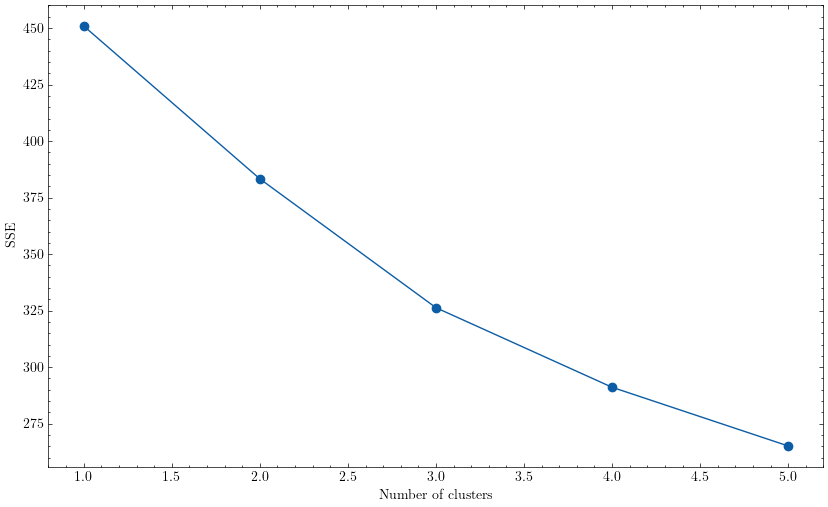

Optimal number of clusters: None


In [ ]:
optimal_k = find_optimal_clusters(vectors, max_k=5)

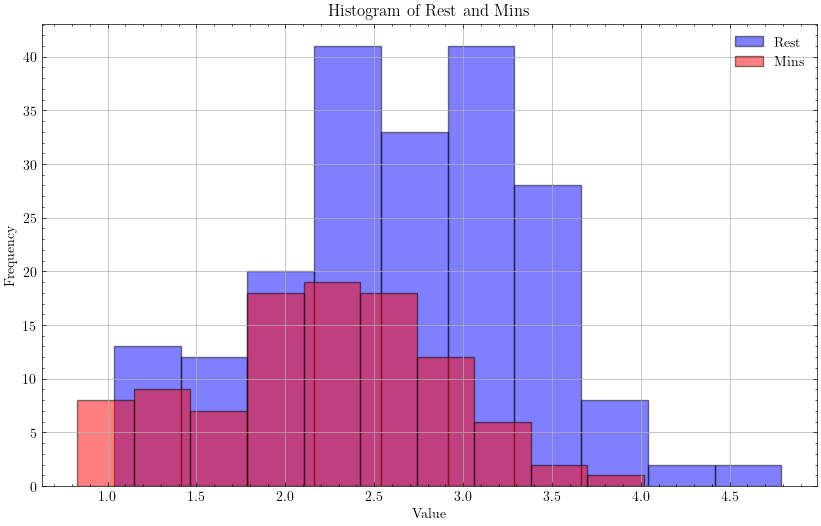

In [ ]:
norm_alphas = state.params['params']['alpha'] * state.params['params']['beta']
norm_betas = state.params['params']['beta'] / state.params['params']['beta']
norm_gammas = state.params['params']['gamma'] / state.params['params']['beta']

vectors = jnp.concatenate((state.params['params']['alpha'], state.params['params']['beta'], state.params['params']['gamma']), axis=0).T

rest = []
mins = []
for vec in vectors:
    temp = []
    for nls in vec_nls:
        temp.append(jnp.linalg.norm(vec - nls))
    
    mins.append(jnp.min(jnp.array(temp)))
    temp.remove(jnp.min(jnp.array(temp)))
    rest.append(temp)
    
    
plt.figure(figsize=(10, 6))
plt.hist([item for sublist in rest for item in sublist], bins=10, edgecolor='black', alpha=0.5, label='Rest', color='blue')
plt.hist(mins, bins=10, edgecolor='black', alpha=0.5, label='Mins', color='red')
plt.title('Histogram of Rest and Mins')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


## Big Test

In [22]:
seeds = jnp.arange(100, dtype=int)
num_epochs = 201
batch_size = 64
all_vectors = []

for seed in seeds:
    print("Run:", seed)
    train_batches = create_batches(train_inputs, train_outputs, batch_size, seed)
    test_batches = create_batches(test_inputs, test_outputs, batch_size, seed)

    key = random.key(seed)
    key, subkey = random.split(key)
    params = model.init(subkey, dummy_input)
    optimizer = adam(learning_rate=0.001)
    state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_x, batch_y in train_batches:
            state, loss = train_step(state, batch_x, batch_y)
            epoch_loss += loss

        if epoch % 50 == 0:
            test_loss = evaluate(state, test_batches)
            print(f"Epoch {epoch}, Loss: {epoch_loss/len(train_batches)}, Test Loss: {test_loss}")


    vectors = jnp.concatenate((state.params['params']['alpha'], state.params['params']['beta']), axis=0).T
    all_vectors.append(vectors)

Run: 0
Epoch 0, Loss: 13.265409469604492, Test Loss: 2.1426899433135986
Epoch 50, Loss: 0.006892233155667782, Test Loss: 0.006990351248532534
Epoch 100, Loss: 0.006884327158331871, Test Loss: 0.006966743152588606
Epoch 150, Loss: 0.00688108429312706, Test Loss: 0.006968599744141102
Epoch 200, Loss: 0.006878877058625221, Test Loss: 0.006967361085116863
Run: 1
Epoch 0, Loss: 1.5511921644210815, Test Loss: 0.274084210395813
Epoch 50, Loss: 0.013787955977022648, Test Loss: 0.013913080096244812
Epoch 100, Loss: 0.01378414873033762, Test Loss: 0.013891024515032768
Epoch 150, Loss: 0.013781317509710789, Test Loss: 0.013873696327209473
Epoch 200, Loss: 0.010351879522204399, Test Loss: 0.01040315069258213
Run: 2
Epoch 0, Loss: 23.954683303833008, Test Loss: 4.676665306091309
Epoch 50, Loss: 0.004389866255223751, Test Loss: 0.004429798107594252
Epoch 100, Loss: 0.004378410521894693, Test Loss: 0.004442016594111919
Epoch 150, Loss: 0.004374079406261444, Test Loss: 0.004429989960044622
Epoch 200, 

In [23]:
jnp.save("all_vectors.npy", jnp.array(all_vectors))

In [24]:
all_vectors = jnp.load("all_vectors.npy").reshape(500, 6)

/Users/matteogallo/miniforge3/envs/metis_env/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (490) found smaller than n_clusters (491). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/matteogallo/miniforge3/envs/metis_env/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (490) found smaller than n_clusters (492). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/matteogallo/miniforge3/envs/metis_env/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (490) found smaller than n_clusters (493). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/matteogallo/miniforge3/envs/metis_env/lib/python3.13/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (490) found smaller than n_cluster

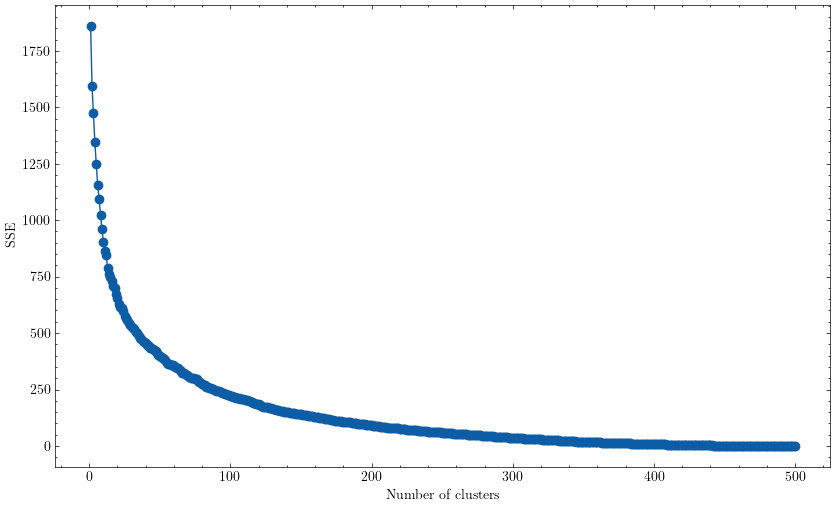

Optimal number of clusters: 72
Cluster Centers:
[[-0.07748098 -0.01469228  0.07788689 -0.01777636  0.03239553 -0.08483329]
 [-0.10468305 -0.6741549   0.76546806 -0.29580268  0.67230064  0.7488107 ]
 [ 1.0815799  -0.72236675 -0.36577123 -0.7651425  -1.0606362   0.5136241 ]
 [ 1.3887777   0.3973378  -0.8870789  -0.48193115  0.83439225 -0.6702816 ]
 [-0.4541593   0.03766261 -0.21216422  0.61312497 -0.10756929 -0.0989966 ]
 [-1.0010818   0.8653691  -0.3922304  -0.6173848  -1.0660559  -0.5882574 ]
 [-1.1281644   0.6619837   0.20483871  1.1077945   1.9289473  -0.02128129]
 [ 0.28978455 -0.02204726 -0.77770346  2.0541294  -0.1803272   0.5114588 ]
 [-1.4575949  -0.86682254  1.5056479   0.40744925 -0.41461188 -0.15576378]
 [ 0.05474557 -0.15290004 -0.79950494 -0.17504945 -0.0125541   0.29836532]
 [ 0.37184256 -0.7541968   0.18915546 -1.0274515  -0.48941004 -0.30253246]
 [-0.06544752 -0.36756796  0.16644417  0.5208194  -1.0855873  -2.1933653 ]
 [ 0.57066923 -1.4015387  -0.39468005  0.4136514   0

In [25]:
optimal_k = find_optimal_clusters(all_vectors, max_k=500)

# Apply KMeans clustering with the optimal number of clusters
cluster_centers, labels = apply_kmeans(all_vectors, optimal_k)

# Print the cluster centers
print("Cluster Centers:")
print(cluster_centers)

In [26]:
# Compute the rank of the matrix
rank = jnp.linalg.matrix_rank(all_vectors.T)
print(f"Number of linearly independent vectors: {rank}")

Number of linearly independent vectors: 6
